In [3]:
# Stratgies Design + Portfolio Analytics
# Author: Man Hei LI
# Date -- 30 May 2024

# !pip install these packages if necessary (e.g. #!pip3 install scipy)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime
from functools import reduce

In [159]:
# Get Dataframe for analysis
dir = '/Users/mh_147/Downloads/'

# read dataframe
weights = pd.read_excel(dir+'Weights_Price_data.xlsx',sheet_name='Asset Allocation Weights') 
assets = pd.read_excel(dir+'Weights_Price_data.xlsx',sheet_name='Price Series')

print(weights.head(5))
print(weights.tail(1))
print(assets.head(5))
print(assets.tail(1))

  Unnamed: 0  MSCI US   MSCI EU  MSCI Japan  MSCI Asia ex JP   MSCI EM  \
0 2010-01-01  0.30137  0.041096    0.054795         0.027397  0.054795   
1 2010-01-04      NaN       NaN         NaN              NaN       NaN   
2 2010-01-05      NaN       NaN         NaN              NaN       NaN   
3 2010-01-06      NaN       NaN         NaN              NaN       NaN   
4 2010-01-07      NaN       NaN         NaN              NaN       NaN   

    HY Bds  IG Corp Bds      TIPS  EM Debt  US Gov Bds  
0  0.09589     0.164384  0.027397  0.09589    0.136986  
1      NaN          NaN       NaN      NaN         NaN  
2      NaN          NaN       NaN      NaN         NaN  
3      NaN          NaN       NaN      NaN         NaN  
4      NaN          NaN       NaN      NaN         NaN  
     Unnamed: 0   MSCI US   MSCI EU  MSCI Japan  MSCI Asia ex JP   MSCI EM  \
3728 2024-05-10  0.369863  0.041096    0.054795         0.027397  0.054795   

       HY Bds  IG Corp Bds      TIPS  EM Debt  US Gov Bd

In [7]:
# Write a function to re-order assets same as weights

def reorder(assets_df):
    org_list = assets_df.columns
    new_list = [org_list[0],\
                org_list[6],org_list[7],org_list[8],org_list[9],org_list[10],\
                org_list[4],org_list[1],org_list[3],org_list[5],org_list[2]]
    new_df = assets_df[new_list]
    return new_df

In [9]:
reorder(assets).head()

,Unnamed: 0,MSCI US,MSCI EU,MSCI Japan,MSCI Asia ex JP,MSCI EM,HY Bds,IG Corp Bds,TIPS,EM Debt,US Gov Bds
0,1999-11-30,2922.436,3234.530,4926.217,135.730689,130.231583,107.871000,95.904032,121.217651,223.5045,964.78
1,1999-12-01,2947.318,3265.968,4902.058,136.447560,131.238204,107.989596,95.774157,121.238938,223.5200,963.61
2,1999-12-02,2972.558,3267.466,4883.535,137.413226,132.289763,108.108191,95.668156,121.260226,223.7128,962.54
3,1999-12-03,3023.775,3326.696,4902.146,138.369091,133.386261,108.226787,96.061601,121.281513,225.7066,966.57
4,1999-12-06,3007.278,3381.503,4899.028,140.676411,134.470775,108.345383,96.201025,121.302801,226.2607,967.80


In [10]:
def get_return_summary(input_data):
    df = reorder(input_data)

    # choose time frame, Basic Data Cleaning
    colname = df.columns.tolist()
    df.rename(columns = {colname[0]:'Date'},inplace=True) #add name to first col
    df.dropna(how='any',inplace=True,axis=0)

    choice = 1 #choose 0 for full periods, 1 for 2010-2024 only (timeframe for strategy backtest)
    if choice==0:
        pass
    else:
        df = df[df['Date']>='2009-12-31'] # match port weights timing

    temp_returns = df.drop('Date',axis=1).pct_change()
    returns = temp_returns
    returns.dropna(how='any',axis=0,inplace=True)
    #print(returns.shape)

    col_name = returns.columns 
    stat_name = ['mean','median','vol','95% VaR','99% VaR','min','max','skewness','excess kurtosis'] #len(stat_name) -> 9
    results = pd.DataFrame(index=col_name,columns=stat_name) #set row index + col name

    # statistics tabulation
    results[stat_name[0]] = returns.mean()
    results[stat_name[1]] = returns.median()
    results[stat_name[2]] = returns.std()
    results[stat_name[3]] = returns.quantile(q=0.05)
    results[stat_name[4]] = returns.quantile(q=0.01)
    results[stat_name[5]] = returns.min()
    results[stat_name[6]] = returns.max()
    results = results*100
    results[stat_name[7]] = scipy.stats.skew(returns, axis=0, bias=True)
    results[stat_name[8]] = scipy.stats.kurtosis(returns, axis=0, fisher=True, bias=True)

    return results


In [92]:
#get_return_summary(assets) #assume 2010-2024 only, otherwise change var choice inside the function

In [173]:
dailyret_stat = get_return_summary(assets)
print(dailyret_stat.shape)

# Create a heatmap for results df
# Note first 7 columns are in percentage terms
dailyret_stat.style.background_gradient(cmap='coolwarm',axis=0).format("{:.4f}")

(10, 9)


,mean,median,vol,95% VaR,99% VaR,min,max,skewness,excess kurtosis
MSCI US,0.0525,0.0418,1.0847,-1.6488,-3.1376,-12.1189,9.4059,-0.5151,12.6687
MSCI EU,0.0280,0.0537,1.2023,-1.8471,-3.5025,-13.1020,8.9107,-0.4894,8.4116
MSCI Japan,0.0301,0.0302,1.1393,-1.7492,-2.9258,-8.1995,7.3923,-0.1317,3.9238
MSCI Asia ex JP,0.0223,0.0635,1.0103,-1.6039,-2.8061,-6.1114,5.9354,-0.2986,3.6507
MSCI EM,0.0159,0.0618,1.0103,-1.6232,-2.6917,-6.7026,5.7422,-0.3544,3.9018
HY Bds,0.0239,0.0374,0.2821,-0.3555,-0.8376,-3.5039,2.4677,-2.0954,32.1132
IG Corp Bds,0.0142,0.0213,0.2557,-0.4036,-0.6847,-3.0422,1.7546,-0.8368,9.4622
TIPS,0.0129,0.0194,0.3896,-0.5715,-1.0360,-2.8355,3.8815,0.1981,9.8567
EM Debt,0.0170,0.0273,0.2669,-0.3744,-0.7384,-3.6393,2.0406,-1.9390,23.9907
US Gov Bds,0.0070,0.0136,0.2834,-0.4379,-0.7381,-1.8624,1.6819,0.0241,3.6837


In [188]:
# Yearly performance for each asset (return + sharpe + max drawdown, only 2010-2024 data used)

def cumproduct(series):
    return reduce(lambda x,y: x*y, series)

def get_return_by_year(input_data):
    df = reorder(input_data)

    # Basic Data Cleaning
    colname = df.columns.tolist()
    df.rename(columns = {colname[0]:'Date'},inplace=True) #add name to first col
    df.dropna(how='any',inplace=True,axis=0)
    df = df[df['Date']>='2009-12-31']

    # Generate daily return matrix
    temp_returns = df.drop('Date',axis=1).pct_change()
    temp_returns = temp_returns+1
    returns = pd.concat([df['Date'],temp_returns],axis=1)
    returns.dropna(how='any',axis=0,inplace=True)
    
    # Compile yearly return matrix
    returns['Date'] = pd.to_datetime(df['Date']) #ensure in datetime format
    returns['Year'] = returns['Date'].dt.year #extract year of datetime
    returns.drop('Date',axis=1,inplace=True)
    
    return_df = returns.groupby(["Year"]).agg([cumproduct])
    return_df.columns = [col[0] for col in return_df.columns]
    avg_array = return_df.apply(np.average,axis=0)
    return_df.loc['Total'] = avg_array
    return_df = (return_df-1)*100

    #return_df.reset_index(inplace=True)
    #print(return_df)
    
    # Sharpe Ratio (in here we define annaulized return - 1yr risk-free rate/ annualized vol)
    # ref -- https://quant.stackexchange.com/questions/2260/how-to-annualize-sharpe-ratio?rq=1
    # Our cal --  [E(daily ret)*252 - 1-yr risk-free rate]/ (dailyvol * sqrt(252))

    #risk-free rate on 2010-2024 (beginning of year)
    rf_array = np.array([0.45,0.29,0.12,0.15,0.13,0.25,0.61,0.89,1.83,2.60,1.56,0.10,0.40,4.72,4.80])
    #print(len(rf_array)) -> 15
    #ref -- https://fred.stlouisfed.org/series/DGS1

    unique_years = return_df.index.values.tolist()[:-1]

    sharpe_returns = returns-1
    sharpe_returns['Year'] = sharpe_returns['Year']+1
    sharp_stat = sharpe_returns.groupby(['Year']).agg(['mean','std'])
    sharp_stat.columns = ["_".join(col) for col in sharp_stat.columns]

    sharp_df = pd.DataFrame(index = unique_years, columns = return_df.columns) #set up sharp_df

    for i in range(len(sharp_stat.columns)//2): #tabulate sharpe ratio for each asset
        mean_col = sharp_stat[sharp_stat.columns[2*i]]
        std_col = sharp_stat[sharp_stat.columns[2*i+1]]
        new_col = (mean_col*252-rf_array/100)/(std_col*(252**0.5)) #size (15,)
        sharp_df[return_df.columns[i]] = new_col

    avg_array2 = sharp_df.apply(np.average,axis=0)
    sharp_df.loc['Average'] = avg_array2
    #print(sharp_df)
    #we assume in 2024 the current sample is representative of whole year

    # Maximum Drawdown within the year
    mdd_df = pd.DataFrame(index = unique_years, columns = return_df.columns)
    for j in unique_years:
        temp_df = returns[returns['Year']==j].copy()
        temp_df.drop(['Year'],axis=1,inplace=True)
        cumret = temp_df.cumprod(axis=0)
        peak = cumret.cummax(axis=0)
        maxdiff = peak-cumret
        maxdiff = maxdiff.max(axis=0)
        mdd_df.loc[j] = maxdiff*100

    avg_array3 = mdd_df.apply(np.average,axis=0)
    mdd_df.loc['Average'] = avg_array3
    #print(mdd_df)
        
    return return_df, sharp_df, mdd_df

In [163]:
return_df, sharp_df, mdd_df = get_return_by_year(assets)

In [189]:
#Yearly Return Heatmap
return_df.style.background_gradient(cmap='coolwarm',axis=None).format("{:.2f}") #heatmap 

,MSCI US,MSCI EU,MSCI Japan,MSCI Asia ex JP,MSCI EM,HY Bds,IG Corp Bds,TIPS,EM Debt,US Gov Bds
Year,,,,,,,,,,
2010,14.77,3.88,15.44,18.13,18.88,15.06,7.25,4.86,12.84,5.87
2011,1.36,-11.06,-14.33,-15.60,-18.42,3.63,4.79,10.79,6.97,9.81
2012,15.33,19.12,8.18,22.31,18.22,19.25,10.92,6.71,17.95,1.99
2013,31.79,25.23,27.16,3.41,-2.60,6.47,0.07,-4.16,-4.12,-2.75
2014,12.69,-6.18,-4.02,2.82,-2.19,2.58,7.60,9.37,4.76,5.05
2015,0.69,-2.84,9.57,-9.37,-14.92,-0.69,-0.24,-0.55,1.29,0.84
2016,10.89,-0.40,2.38,6.75,11.19,15.60,6.22,10.45,9.88,1.04
2017,21.19,25.51,23.99,36.98,37.28,8.42,5.70,3.19,8.17,2.31
2018,-5.04,-14.86,-12.88,-13.92,-14.57,-2.72,-1.00,0.28,-2.46,0.86


In [190]:
# Sharpe Heatmap
# axis=1, heatmap by year and see which asset class performs better in that year
sharp_df.style.background_gradient(cmap='coolwarm',axis=1).format("{:.2f}") 

,MSCI US,MSCI EU,MSCI Japan,MSCI Asia ex JP,MSCI EM,HY Bds,IG Corp Bds,TIPS,EM Debt,US Gov Bds
2010,0.81,0.25,0.84,0.93,1.00,3.53,1.77,0.97,2.70,1.12
2011,0.16,-0.25,-0.55,-0.58,-0.80,0.69,1.08,1.96,1.62,1.84
2012,1.15,0.93,0.57,1.42,1.19,6.44,3.51,1.64,6.22,0.56
2013,2.49,1.58,1.20,0.31,-0.14,2.04,-0.01,-0.90,-0.97,-0.97
2014,1.07,-0.45,-0.15,0.31,-0.15,0.81,2.79,2.40,1.41,1.80
2015,0.10,-0.09,0.56,-0.54,-0.92,-0.25,-0.11,-0.10,0.33,0.16
2016,0.79,0.05,0.19,0.45,0.66,3.06,1.67,1.65,2.28,0.12
2017,2.73,2.37,1.86,3.63,3.26,3.99,1.77,0.47,3.11,0.47
2018,-0.32,-1.21,-0.85,-1.06,-1.04,-1.64,-1.18,-0.37,-1.49,-0.34
2019,1.96,1.62,1.26,1.32,1.26,3.54,2.87,0.88,3.94,0.95


In [205]:
# Max Drawdown Heatmap
mdd_df.style.background_gradient(cmap='coolwarm',axis=None).format("{:.2f}")

,MSCI US,MSCI EU,MSCI Japan,MSCI Asia ex JP,MSCI EM,HY Bds,IG Corp Bds,TIPS,EM Debt,US Gov Bds
2010,17.42,23.96,15.26,19.84,19.05,5.03,3.78,4.42,5.41,4.51
2011,20.77,35.20,23.67,31.08,31.71,10.29,3.00,2.69,7.14,3.12
2012,11.18,20.52,17.06,17.86,20.64,3.40,1.08,1.60,3.62,2.49
2013,6.82,10.50,15.66,15.95,17.71,5.82,5.16,9.12,9.24,4.56
2014,8.13,17.29,12.10,13.99,19.07,6.28,1.29,2.84,6.34,1.32
2015,12.67,17.89,20.10,28.79,29.97,6.56,3.86,5.11,4.71,3.38
2016,10.89,13.64,17.69,12.89,13.29,4.05,3.87,5.83,5.22,6.13
2017,2.75,3.16,4.47,6.02,6.60,1.46,1.39,3.58,1.29,1.85
2018,21.77,23.73,26.26,24.80,27.51,3.94,2.49,2.49,4.70,2.56
2019,7.93,9.72,5.47,11.70,12.60,2.37,2.28,5.34,1.13,2.89


In [146]:
# Data Cleaning before plugging into get_return_summary function
#print(weights.dtypes)
#print(assets.dtypes)

# remove dates without portfolio rebalance
print(weights.shape)
weights.dropna(how='any',inplace=True,axis=0)
print(weights.shape)
#weights

# remove dates if any of the asset prices is not available
print(assets.shape)
assets.dropna(how='any',inplace=True,axis=0)
print(assets.shape)
#assets

assetsfull = assets

(3729, 11)
(569, 11)
(6356, 11)
(6356, 11)


In [165]:
# Generate descriptive and insightful statistics for daily assets data 
# Each col correspond to the statistic, and each row correspond to an asset, save in a df named results

#!pip3 install scipy
import scipy

choice = 1 #choose 0 for full periods, 1 for 2010-2024 only
if choice==0:
    assets = assetsfull
else:
    assets = assetsfull[assetsfull['Date']>='2009-12-31'] # match port weights timing

# we first generate a return matrix for these assets
temp_returns = assets.drop('Date',axis=1).pct_change()
returns = temp_returns
#returns = pd.concat([assets['Date'],temp_returns],axis=1) IF date is required
returns.dropna(how='any',axis=0,inplace=True)
#print(returns.head())

# Summary Statistics
def geta_return_summary(input_data):
    #print(assets.describe())
    col_name = returns.columns #adjust if date is used
    stat_name = ['mean','median','vol','95% VaR','99% VaR','min','max','skewness','excess kurtosis'] #len(stat_name) -> 9
    results = pd.DataFrame(index=col_name,columns=stat_name) #set row index + col name

    # statistics tabulation
    results[stat_name[0]] = returns.mean()
    results[stat_name[1]] = returns.median()
    results[stat_name[2]] = returns.std()
    results[stat_name[3]] = returns.quantile(q=0.05)
    results[stat_name[4]] = returns.quantile(q=0.01)
    results[stat_name[5]] = returns.min()
    results[stat_name[6]] = returns.max()
    results = results*100
    results[stat_name[7]] = scipy.stats.skew(returns, axis=0, bias=True)
    results[stat_name[8]] = scipy.stats.kurtosis(returns, axis=0, fisher=True, bias=True) #fisher=T for excess kurt 

    return results

results = geta_return_summary(returns) # assume returns is a df with date + all returns
print(results.shape) # check dimensions

(10, 9)


In [166]:
# Create a heatmap for results df
# Note first 7 columns are in percentage terms
results.style.background_gradient(cmap='coolwarm',axis=0)

,mean,median,vol,95% VaR,99% VaR,min,max,skewness,excess kurtosis
IG Corp Bds,0.014160,0.021260,0.255677,-0.403553,-0.684716,-3.042245,1.754632,-0.836844,9.462156
US Gov Bds,0.007036,0.013636,0.283385,-0.437914,-0.738134,-1.862431,1.681900,0.024069,3.683728
TIPS,0.012852,0.019423,0.389577,-0.571499,-1.036040,-2.835528,3.881481,0.198080,9.856725
HY Bds,0.023861,0.037357,0.282107,-0.355460,-0.837584,-3.503892,2.467726,-2.095433,32.113202
EM Debt,0.017025,0.027328,0.266877,-0.374414,-0.738374,-3.639327,2.040604,-1.939021,23.990683
MSCI US,0.052506,0.041753,1.084731,-1.648771,-3.137590,-12.118928,9.405941,-0.515128,12.668714
MSCI EU,0.028045,0.053663,1.202283,-1.847129,-3.502503,-13.101997,8.910746,-0.489414,8.411626
MSCI Japan,0.030112,0.030212,1.139306,-1.749170,-2.925829,-8.199499,7.392275,-0.131729,3.923786
MSCI Asia ex JP,0.022346,0.063496,1.010291,-1.603939,-2.806084,-6.111441,5.935382,-0.298573,3.650658
MSCI EM,0.015931,0.061782,1.010295,-1.623171,-2.691656,-6.702616,5.742239,-0.354379,3.901826


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


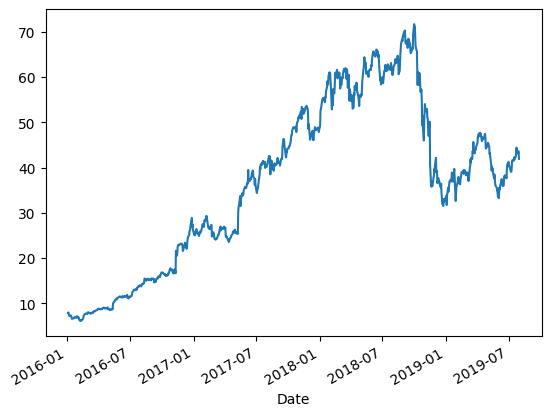

In [50]:
# merge 2 stock data tgt
data1 = yf.download('AAPL','2016-01-01','2019-08-01')
data2 = yf.download('NVDA','2016-01-01','2019-08-01')
df = data1.merge(data2, how='inner',on='Date',suffixes=('_AAPL','_NVDA')) #suffixes arz takes a tuple, join method like SQL
# Alternatively, specify keys to merge for left_df and right_df -> left_on = '?' and right_on = '?'

df['Adj Close_NVDA'].plot()
plt.show()

In [9]:
# Combo Charts Plotting
x = range(0, 5)
y1 = [1, 2, 3, 4, 5]
y2 = [3, 3, 4, 5, 6]

#fig, ax1 = plt.subplots()
#e.g. plot(x, y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

# First line on primary y-axis
ax1.plot(x, y1, 'g-')
ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')

# Secondary y-axis for the second line
ax2 = ax1.twinx()
ax2.plot(x, y2, 'b-')
ax2.set_ylabel('Y2 data', color='b')

#plt.show()

Text(0, 0.5, 'Y2 data')

In [24]:
# Two Subplots
x = range(0, 5)
y1 = [1, 2, 3, 4, 5]
y2 = [3, 3, 4, 5, 6]

#fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(x, y1, 'g-')
ax1.set_xlabel('X1 data')
ax1.set_ylabel('Y1 data', color='g')

ax2.plot(x, y2, 'b-')
ax2.set_xlabel('X2 data')
ax2.set_ylabel('Y2 data', color='b')

#plt.tight_layout()
#plt.show()


Text(0, 0.5, 'Y2 data')

[*********************100%%**********************]  2 of 2 completed


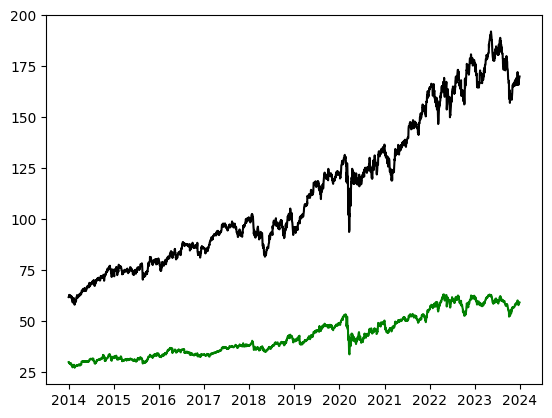

In [115]:
# Plot Pepsi and KO stock price + another chart showing daily returns
# Use a ticker list instead this time

ticker_list = ['KO','PEP']
df = yf.download(ticker_list,'2014-01-01','2023-12-31')
date = df.reset_index()['Date']
#print(df.head())
#print(df['Adj Close']['KO'])
fig,ax=plt.subplots()
ax.plot(date,df['Adj Close']['KO'],'green')
ax.plot(date,df['Adj Close']['PEP'],'black')
plt.show()

#calculate returns
ret = df['Adj Close'].pct_change(periods=1) #default is one
ret = ret.dropna(axis=0)
ret.reset_index(inplace=True)
#print(ret)

#fig,ax=plt.subplots()
#ax.plot(ret["Date"],ret["KO"],'green')
#ax.plot(ret["Date"],ret["PEP"],'black')
#plt.show()

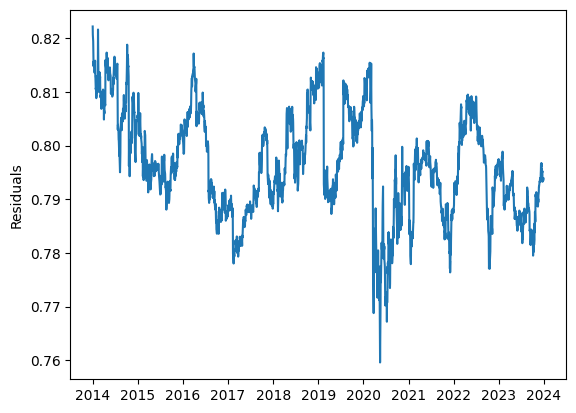

In [116]:
# check residuals then stationarity for pairs trading
from sklearn.linear_model import LinearRegression

#y = np.array(ret['KO'])
y = np.log(np.array(df['Adj Close']['KO']))
x = np.log(np.array(df['Adj Close']['PEP']).reshape(-1,1))
x_org = np.log(np.array(df['Adj Close']['PEP']))

spread = y/x_org

#x_org = np.array(ret['PEP'])
#x = np.array(ret['PEP']).reshape(-1,1)

'''model = LinearRegression()
model.fit(x, y)

beta = model.coef_[0]
alpha = model.intercept_
spread = y - x_org*beta - alpha
print("alpha:",alpha,"beta:",beta, spread.shape)'''

fig, ax = plt.subplots()
ax.plot(date,spread)
plt.ylabel('Residuals')
plt.show()

In [117]:
# Check Residuals with ADF (con't)
#!pip3 install statsmodels

import statsmodels.api as sm

adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
print(f"ADF Test Statistics: {adf[0]}; p-value: {adf[1]}")

ADF Test Statistics: -4.637043822452474; p-value: 0.00011031576311466983


Mean; 0.7963977784217352 and Sigma: 0.009805242450574977


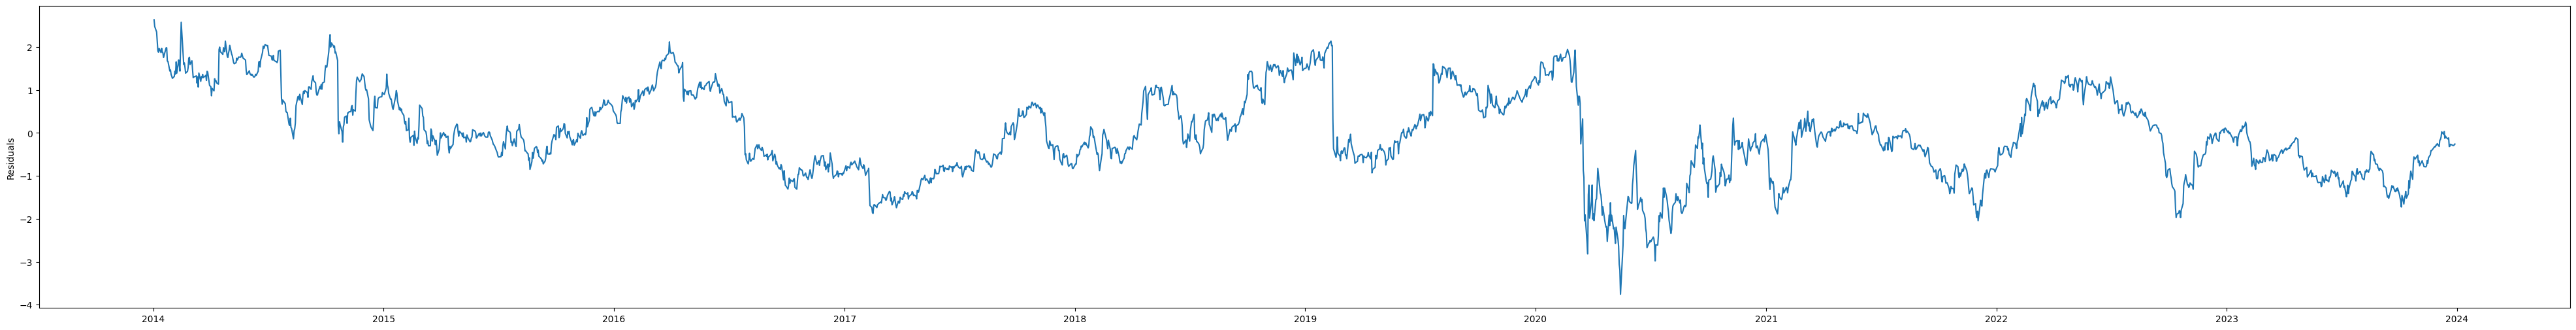

In [118]:
# Analyze normalized z-spread

sigma = spread.std()
mean = spread.mean()
print(f"Mean; {mean} and Sigma: {sigma}")

zscore_spread = (spread-mean)/sigma

fig, ax = plt.subplots(figsize=(50,6))
ax.plot(date,zscore_spread)
plt.ylabel('Residuals')
plt.show()


In [119]:
# Generate trading signal to enter/exit
# if z-score lower than ??, long KO short Pepsi
# if z-score higher than ??, short KO long Pepsi
# if z-score between [??,??] -> close position

backtestpt = pd.concat([date,pd.DataFrame(zscore_spread,columns=['z-score spread'])],axis=1)

# Concat returns and ensure row # the same
backtestpt = backtestpt.merge(ret[["Date","KO","PEP"]],how='inner',on="Date")
backtestpt[['KO_trade','PEP_trade','action','cum_ret']]=0

#backtestpt = backtestpt[backtestpt["Date"].isin(ret["Date"])] -> isin can be a list of string too
#backtestpt = pd.concat([backtestpt,ret["KO"],ret["PEP"]],axis=1) 

def rowcheck(df):
    if df['z-score spread'] > 1.5:
        df['action'] = 1
    elif df['z-score spread'] < -1.5:
        df['action'] = -1
    else:
        pass
    return df

backtestpt = backtestpt.apply(rowcheck,axis=1)

templist = []
zscorelist = backtestpt['z-score spread'].tolist()
actionlist = backtestpt['action'].tolist()

for i in range(len(zscorelist)):
    zscore = zscorelist[i]
    action = actionlist[i]
    if i==0:
        templist.append(action)
    else:
        if status == action:
            templist.append(action)
        elif status == 1 and action == 0:
            if zscore>0.25:
                action = 1
            templist.append(action)    
        elif status == -1 and action == 0:
            if zscore<-0.25:
                action = -1
            templist.append(action)
        else:
            templist.append(action)

    status = action
    zscore, action = 0,0

backtestpt['action'] = templist
backtestpt.head()
#backtestpt.to_csv("/users/mh_147/Downloads/backtestpt2.csv",index=False)


,Date,z-score spread,KO,PEP,KO_trade,PEP_trade,action,cum_ret
0,2014-01-03,2.477099,-0.004919,0.001705,0,0,1,0
1,2014-01-06,2.350775,-0.004696,0.000487,0,0,1,0
2,2014-01-07,2.131637,0.002980,0.014585,0,0,1,0
3,2014-01-08,1.913296,-0.011142,-0.002876,0,0,1,0
4,2014-01-09,1.877630,-0.005258,-0.004685,0,0,1,0


In [120]:
# Continue showcasing the results

backtestpt.loc[backtestpt['action']==1,'KO_trade'] = -1
backtestpt.loc[backtestpt['action']==1,'PEP_trade'] = 1
backtestpt.loc[backtestpt['action']==-1,'KO_trade'] = 1
backtestpt.loc[backtestpt['action']==-1,'PEP_trade'] = -1

backtestpt['cum_ret'] = (1+backtestpt['KO']*backtestpt['KO_trade'])*(1+backtestpt['PEP']*backtestpt['PEP_trade'])
backtestpt['cum_ret'] = backtestpt['cum_ret'].cumprod()
backtestpt

,Date,z-score spread,KO,PEP,KO_trade,PEP_trade,action,cum_ret
0,2014-01-03,2.477099,-0.004919,0.001705,-1,1,1,1.006633
1,2014-01-06,2.350775,-0.004696,0.000487,-1,1,1,1.011852
2,2014-01-07,2.131637,0.002980,0.014585,-1,1,1,1.023550
3,2014-01-08,1.913296,-0.011142,-0.002876,-1,1,1,1.031978
4,2014-01-09,1.877630,-0.005258,-0.004685,-1,1,1,1.032544
...,...,...,...,...,...,...,...,...
2510,2023-12-22,-0.263824,0.005691,0.004252,0,0,0,1.265287
2511,2023-12-26,-0.292852,0.004115,0.007037,0,0,0,1.265287
2512,2023-12-27,-0.292363,0.002561,0.003198,0,0,0,1.265287
2513,2023-12-28,-0.277898,0.000681,-0.000059,0,0,0,1.265287


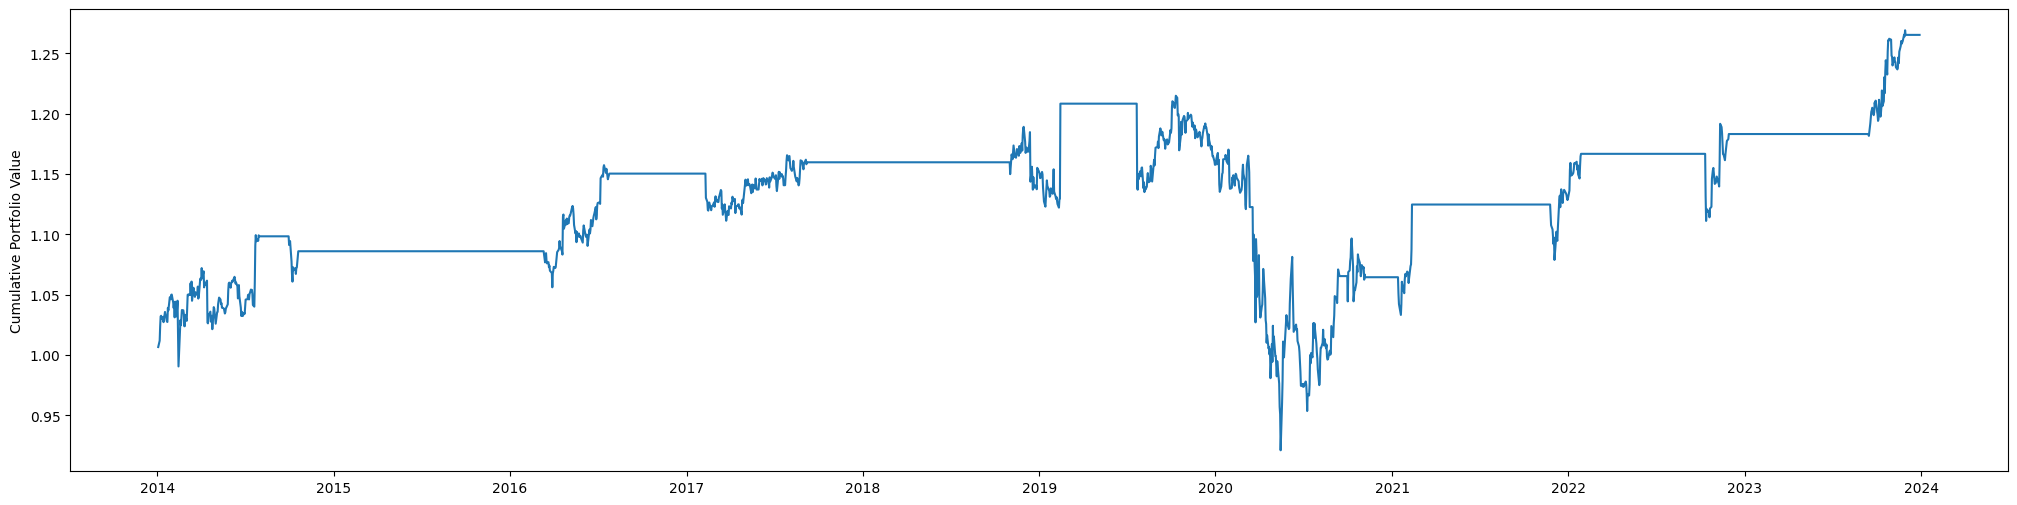

In [121]:
# plot the results

date = backtestpt['Date'].tolist()
cumret = backtestpt['cum_ret'].tolist()

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(date,cumret)
plt.ylabel('Cumulative Portfolio Value')
plt.show()


In [39]:
# Backtesting, use backtrader as it is open-source
#!pip install backtrader

#Note in some cases may need to downgrade matplotlib
# !pip uninstall matplotlib
# !pip install matplotlib==3.2.2

import backtrader as bt
from datetime import datetime

from __future__ import (absolute_import, division, print_function, unicode_literals)

if __name__ == '__main__':
    cerebro = bt.Cerebro() #set
    data = bt.feeds.PandasData(dataname = df['Adj Close'][['KO','PEP']],
                               fromdate = '', todate = '')


    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portoflio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
Final Portoflio Value: 100000.00
